# Instalar a biblioteca wisardpkg

In [ ]:
!pip3 install wisardpkg

     |████████████████████████████████| 133kB 9.4MB/s 
     |████████████████████████████████| 194kB 8.9MB/s 
  ERROR: Failed building wheel for wisardpkg
  Running setup.py clean for wisardpkg
Failed to build wisardpkg
    Running setup.py install for wisardpkg ... done


# Montar o diretório do Google Drive contendo o conjunto de dados

In [ ]:
from google.colab import drive
drive.mount('/drive')
%cd /drive/Shareddrives/Redes\ Neurais\ Sem\ Peso\/Dataset/audio

Mounted at /drive
/drive/Shareddrives/Redes Neurais Sem Peso/Dataset/audio


# Importar as bibliotecas

In [ ]:
import os
import wisardpkg as wp
import pandas as pd
import numpy as np
import librosa
import time
import matplotlib.pyplot as plt
from librosa.feature import mfcc as mfcc_extraction
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Extrair os coeficientes MFCC para os áudios

In [ ]:
# Garantir que na pasta do dataset só há as pastas referentes às 7 classes dos áudios
classes = ['orange',
          'lime',
          'pineapple',
          'apple',
          'banana',
          'kiwi',
          'peach']
para_remover = [arquivo for arquivo in os.listdir() if arquivo not in classes]

for arquivo in para_remover:
  !rm -r {arquivo}

In [ ]:
# Pseudocódigo 
# ============
# Seja D um dicionário
# Para cada classe C
  # D[C] = []
  # Para cada áudio A da classe C
    # Carrega o áudio A, convertendo-o para mono e com taxa de amostragem 44.1kHz
    # Seja mfcc as features extraídas de A para cada frame (col são coeficientes e linhas são frames)
    # D[C] += [mfcc_DataFrame]

D = {}
for C in os.listdir():
  D[C] = []
  diretorio_classe_C = "./{}".format(C)
  print(diretorio_classe_C)
  nomes_audios_classe_C = os.listdir(diretorio_classe_C)
  for A in nomes_audios_classe_C:
    audio,sr = librosa.load("{}/{}".format(diretorio_classe_C,A), sr = 44100)
    mfcc = mfcc_extraction(audio,sr,n_mfcc=13,n_fft=2048,hop_length=512)
    D[C] += [pd.DataFrame(data = np.transpose(mfcc), columns = ['mfcc_%d'%i for i in range(13)])]

./orange
./lime
./pineapple
./apple
./banana
./kiwi
./peach


## Aplicar a técnica Append Sum em cada áudio

In [ ]:
# Pseudocódigo
# ============
# Seja D um dicionário, cujas chaves são as classes e os valores correspondem a uma lista, 
# onde cada elemento da lista é um DataFrame Pandas referente a um áudio da classe correspondente
# onde cada linha é um frame do áudio e cada coluna corresponde a um coeficiente MFCC.
# Para cada classe C
  # Para cada áudio A da classe C (A é um DataFrame Pandas)
    # Para cada coluna K de A (K é um Series Pandas)
      # A[K] = AppendSum(K)

# Pseudocódigo AppendSum(K)
# =========================
# K' = [K[0]]
# Para linha = 2 até tamanho(K)
  # K' += [K'[linha-1] + K[linha]]
# Retorna Series(K')

def AppendSum(sequencia):
  """O argumento deve ser um pandas Series."""
  nova_sequencia = [sequencia[0]]
  for linha in (sequencia.index)[1:]:
    nova_sequencia += [nova_sequencia[linha-1] + sequencia[linha]]
  return pd.Series(nova_sequencia)

for classe in list(D.keys()):
  for A in D[classe]:
    for coluna in A.columns:
      A[coluna] = AppendSum(A[coluna])

# Separar em conjuntos de treinamento e teste

In [ ]:
D_treino = {}
D_teste = {}
for classe in list(D.keys()):
  D_treino[classe], D_teste[classe] = train_test_split(D[classe],train_size=12,random_state=0,shuffle=True)

# Aplicar Z-Score nos conjuntos de treinamento e teste

In [ ]:
# Concatenar todos áudios do conjunto de treinamento
tamanho_seqs_treino = list()
concatenado_treino = pd.DataFrame(columns = D_treino['apple'][0].columns)
for classe in list(D_treino.keys()):
  for A in D_treino[classe]:
    concatenado_treino = concatenado_treino.append(A)
    tamanho_seqs_treino.append(A.shape[0])
concatenado_treino.reset_index(drop=True, inplace=True)

# Concatenar todos os áudios do conjunto de teste
tamanho_seqs_teste = list()
concatenado_teste = pd.DataFrame(columns = D_teste['apple'][0].columns)
for classe in list(D_teste.keys()):
  for A in D_teste[classe]:
    concatenado_teste = concatenado_teste.append(A)
    tamanho_seqs_teste.append(A.shape[0])
concatenado_teste.reset_index(drop=True, inplace=True)

scaler = StandardScaler()

# Ajustar o Z-Score a partir do conjunto de treinamento
scaler.fit(concatenado_treino)

# Aplicar o Z-Score em ambos os conjuntos de treinamento e teste
concatenado_treino = pd.DataFrame(data = scaler.transform(concatenado_treino), columns = D['apple'][0].columns)
concatenado_teste = pd.DataFrame(data = scaler.transform(concatenado_teste), columns = D['apple'][0].columns)

# Desconcatenar todos os áudios do conjunto de treinamento
i = 0
sum = 0
D_treino_padronizado = dict() 
for classe in list(D_treino.keys()):
  new_list = list()
  for j in range(len(D_treino[classe])):
    new_df = concatenado_treino.iloc[sum:(sum+tamanho_seqs_treino[i])].copy(deep=True)
    new_list.append(new_df)
    sum += tamanho_seqs_treino[i]
    i += 1
  D_treino_padronizado[classe] = new_list

# Desconcatenar todos os áudios do conjunto de teste
i = 0
sum = 0
D_teste_padronizado = dict() 
for classe in list(D_teste.keys()):
  new_list = list()
  for j in range(len(D_teste[classe])):
    new_df = concatenado_teste.iloc[sum:(sum+tamanho_seqs_teste[i])].copy(deep=True)
    new_list.append(new_df)
    sum += tamanho_seqs_teste[i]
    i += 1
  D_teste_padronizado[classe] = new_list

# Aplicar a função tanh em todos os valores de ambos os conjuntos

In [ ]:
# Aplicar tanh no conjunto de treinamento
for classe in list(D_treino_padronizado.keys()):
  for i,A in enumerate(D_treino_padronizado[classe]):
    D_treino_padronizado[classe][i] = A.apply(np.tanh,axis=1)

# Aplicar tanh no conjunto de teste
for classe in list(D_teste_padronizado.keys()):
  for i,A in enumerate(D_teste_padronizado[classe]):
    D_teste_padronizado[classe][i] = A.apply(np.tanh,axis=1)

# Replicar features dos dois frames anteriores e concatenar com o atual para ambos os conjuntos

In [ ]:
nomes_colunas = ["mfcc_%d_tempo(%d)"%(i%13,-int(i/13)) for i in range(39)]

# Replicar features no conjunto de treinamento
for classe in list(D_treino_padronizado.keys()):
  for i,A in enumerate(D_treino_padronizado[classe]):
    D_treino_padronizado[classe][i] = pd.concat([A,A.shift(1),A.shift(2)],axis=1).fillna(0)
    D_treino_padronizado[classe][i].reset_index(drop=True, inplace=True)
    D_treino_padronizado[classe][i].columns = nomes_colunas

# Replicar features no conjunto de teste
for classe in list(D_teste_padronizado.keys()):
  for i,A in enumerate(D_teste_padronizado[classe]):
    D_teste_padronizado[classe][i] = pd.concat([A,A.shift(1),A.shift(2)],axis=1).fillna(0)
    D_teste_padronizado[classe][i].reset_index(drop=True, inplace=True)
    D_teste_padronizado[classe][i].columns = nomes_colunas

# Definir função para aplicar KernelCanvas

**Será usada diversas vezes durante a escolha dos parâmetros**

In [ ]:
def binarizar_sequencia_com_KernelCanvas(sequencia,**kwargs):
  """ Dada uma sequencia, ou seja, um DataFrame cujas linhas são as amostras da sequência e as colunas são as
      features de cada amostra, retorna uma lista de novas entradas mapeadas a partir dos kernels. Essa lista
      tem tamanho bits_por_kernel*numero_kernels e contém apenas zeros e uns. """
  dimensao = len(sequencia.columns)
  kc = wp.KernelCanvas(
      dimensao, 
      kwargs['numberOfKernels'], 
      bitsByKernel     = kwargs['bitsByKernel'], 
      activationDegree = kwargs['activationDegree']
  )
  return kc.transform(sequencia.to_numpy())

In [ ]:
# Essa função é mais geral e é capaz de aplicar KernelCanvas em diversas sequências através de uma única chamada
def binarizar_conjunto_com_KernelCanvas(conjunto,**kwargs):
  """ Dada um conjunto, ou seja, um dicionário cujas chaves são as classes e os valores são listas contendo todas 
      as sequências daquela classe, retorna um dicionário contendo as chaves 'classes' e 'exemplos'. O valor da
      chave 'exemplos' é uma lista contendo todos os exemplos do conjunto após a passar pelo KernelCavas, ou seja, 
      cada exemplo é uma lista contendo apenas zeros e uns. Já o valor da chave 'classes' contém uma lista onde 
      cada elemento da lista é a classe do exemplo correspondente à mesma posição. """
  dimensao = len(conjunto[list(conjunto.keys())[0]][0].columns)

  kc = wp.KernelCanvas(
      dimensao, 
      kwargs['numberOfKernels'], 
      bitsByKernel = kwargs['bitsByKernel'], 
      activationDegree = kwargs['activationDegree']
  )

  database = {'exemplos':[],'classes':[]}

  for classe in list(conjunto.keys()):
    for A in conjunto[classe]:
      database['exemplos'] += [kc.transform(A.to_numpy())]
      database['classes'] += [classe]
    
  database['exemplos'] = np.array(database['exemplos'])
  database['classes'] = np.array(database['classes'])

  return database

# Definir função para realizar validação cruzada estratificada

In [ ]:
def multi_class_stratifiedKFold_split(X,y,n_folds=5,shuffle=True,random_state=5):
  partition_size = 1/n_folds

  np.random.seed(random_state)

  # Separar os exemplos por classe
  examples_by_class = {}
  for i,C in enumerate(y):
    if not C in examples_by_class:
      examples_by_class[C] = []
    examples_by_class[C] += [X[i]]
  
  # Embaralhar os exemplos de cada classe
  if shuffle:
    for C in list(examples_by_class.keys()):
      np.random.shuffle(examples_by_class[C])
      
    # Criar as partições
    folds_examples = [[] for fold in range(n_folds)]
    folds_classes = [[] for fold in range(n_folds)]
    for C in list(examples_by_class.keys()):
      number_of_examples_class_C = len(examples_by_class[C])
      for i,example in enumerate(examples_by_class[C]):
        folds_examples[i%(n_folds)] += [example]
        folds_classes[i%(n_folds)] += [C]

  for fold in range(n_folds):
    X_test, y_test = folds_examples[fold], folds_classes[fold]
    X_train, y_train = [],[]
    for f in range(n_folds):
      if f!=fold:
        X_train += folds_examples[f]
        y_train += folds_classes[f]

    X_train, X_test, y_train, y_test = np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test)

    yield (X_train, X_test, y_train, y_test)

In [ ]:
def validacao_cruzada(X, y, metric_func, n_folds = 5, shuffle = True, random_state = 5, classificador = 'wisard', **kwargs):
  """ Parâmetros
      ==========
      X: array 2-dimensional
      y: array 1-demensional
      metric_func: uma função de avaliação. Essa função deve receber os parâmetros y_true e y_pred e retornar um float.
      n_folds: número de partições da validação cruzada
      shuffle: booleano. Se True, embaralha o conjunto antes de dividir as partições
      random_state: int. É usado quando se deseja reproduzir o experimento diversas vezes
      classificador: 'wisard' ou 'cluswisard'
      **kwargs: argumentos do classificador

      Resultado
      =========
      4-tupla: (média de metric_func, desvio padrão de metric_func, média do tempo para aprendizado e classificação de uma
                iteração da validação cruzada, desvio padrão do tempo para aprendizado e classificação de uma iteração da 
                validação cruzada)
  """

  if classificador == 'wisard':
    addressSize = kwargs['addressSize']
    clf = wp.Wisard(
        addressSize,
        **kwargs
    )

  skf = multi_class_stratifiedKFold_split(X,y,n_folds=n_folds,shuffle=shuffle,random_state=random_state)

  performances_metric = []

  elapsed_times = []

  for X_train,X_test,y_train,y_test in skf:
  
    begin_time = time.time()
    clf.train(X_train,y_train)
    predictions = clf.classify(X_test)
    end_time = time.time()

    elapsed_times += [end_time - begin_time]

    performances_metric += [metric_func(y_test,predictions)]
    
  elapsed_times += np.array(elapsed_times)
  performances_metric = np.array(performances_metric)

  return (performances_metric.mean(), performances_metric.std(), elapsed_times.mean(), elapsed_times.std())

In [ ]:
kernel_bits = list(range(1,9))
n_kernels = [50,100,200,400,800]
addr_size = list(range(2,21))

resultados = {}

for b in kernel_bits:
  resultados[b] = {}
  
  for k in n_kernels:
    resultados[b][k] = {}
    resultados[b][k]['media_tempo'] = []
    resultados[b][k]['std_tempo'] = []
    resultados[b][k]['media_acuracia'] = []
    resultados[b][k]['std_acuracia'] = []

    for addr in addr_size:
      print("kernel_bits = {}, n_kernels = {}, addressSize = {}\n".format(b, k, addr))
      
      X_treino,y_treino = list(binarizar_conjunto_com_KernelCanvas(D_treino_padronizado,
                                                                   numberOfKernels=k,
                                                                   bitsByKernel=b,
                                                                   activationDegree=0.03).values())

      media_acuracia,std_acuracia,media_tempo,std_tempo = validacao_cruzada(X_treino,y_treino,
                                                                            metric_func=accuracy_score,
                                                                            classificador='wisard',
                                                                            addressSize=addr)
      

      resultados[b][k]['media_tempo'] += [media_tempo]
      resultados[b][k]['std_tempo'] += [std_tempo]
      resultados[b][k]['media_acuracia'] += [media_acuracia]
      resultados[b][k]['std_acuracia'] += [std_acuracia]

kernel_bits = 1, n_kernels = 50, addressSize = 2

kernel_bits = 1, n_kernels = 50, addressSize = 3

kernel_bits = 1, n_kernels = 50, addressSize = 4

kernel_bits = 1, n_kernels = 50, addressSize = 5

kernel_bits = 1, n_kernels = 50, addressSize = 6

kernel_bits = 1, n_kernels = 50, addressSize = 7

kernel_bits = 1, n_kernels = 50, addressSize = 8

kernel_bits = 1, n_kernels = 50, addressSize = 9

kernel_bits = 1, n_kernels = 50, addressSize = 10

kernel_bits = 1, n_kernels = 50, addressSize = 11

kernel_bits = 1, n_kernels = 50, addressSize = 12

kernel_bits = 1, n_kernels = 50, addressSize = 13

kernel_bits = 1, n_kernels = 50, addressSize = 14

kernel_bits = 1, n_kernels = 50, addressSize = 15

kernel_bits = 1, n_kernels = 50, addressSize = 16

kernel_bits = 1, n_kernels = 50, addressSize = 17

kernel_bits = 1, n_kernels = 50, addressSize = 18

kernel_bits = 1, n_kernels = 50, addressSize = 19

kernel_bits = 1, n_kernels = 50, addressSize = 20

kernel_bits = 1, n_kernels = 100, addre

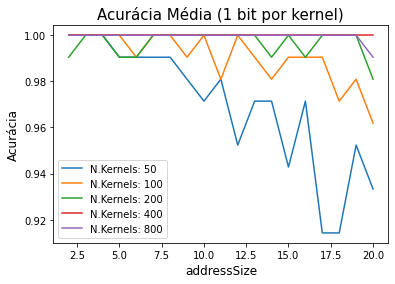

In [ ]:
b = 1
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bit por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

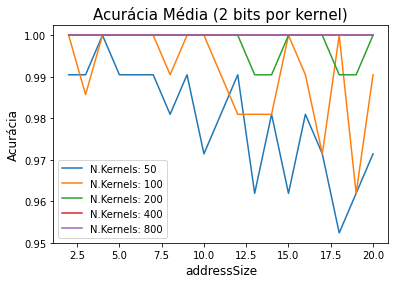

In [ ]:
b = 2
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

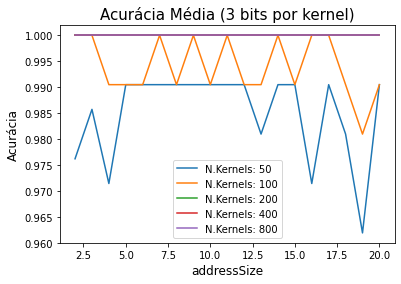

In [ ]:
b = 3
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

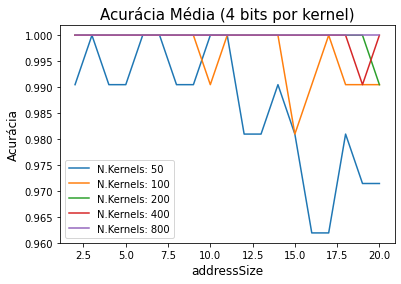

In [ ]:
b = 4
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

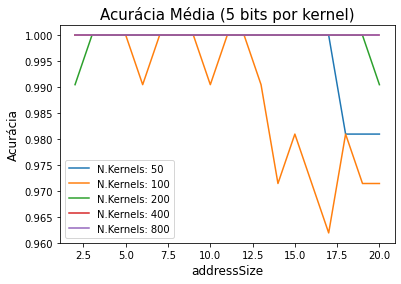

In [ ]:
b = 5
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

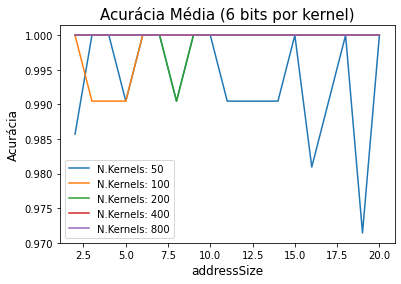

In [ ]:
b = 6
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

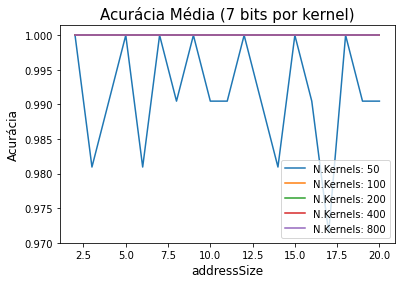

In [ ]:
b = 7
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

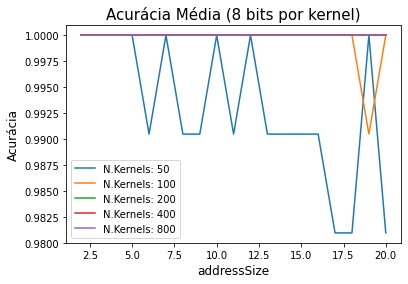

In [ ]:
b = 8
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_acuracia'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Acurácia',size=12)
  plt.title('Acurácia Média (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

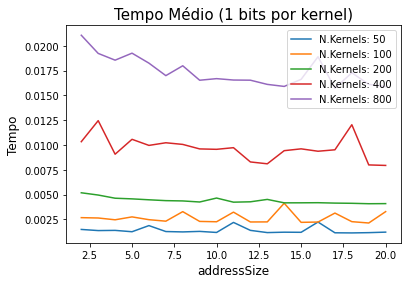

In [ ]:
b = 1
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_tempo'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Tempo',size=12)
  plt.title('Tempo Médio (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

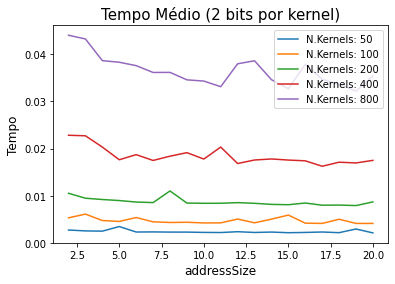

In [ ]:
b = 2
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_tempo'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Tempo',size=12)
  plt.title('Tempo Médio (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

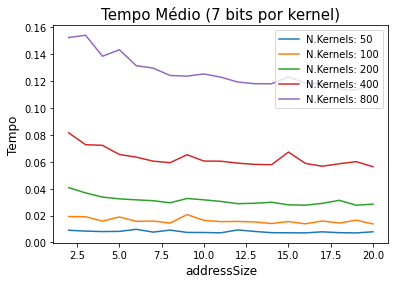

In [ ]:
b = 7
for k in list(resultados[b].keys()):
  plt.errorbar(addr_size,resultados[b][k]['media_tempo'])
  plt.xlabel('addressSize',size=12)
  plt.ylabel('Tempo',size=12)
  plt.title('Tempo Médio (%d bits por kernel)'%(b), size = 15)
  #plt.show()
plt.legend(["N.Kernels: %d"%i for i in list(resultados[b].keys())])

In [ ]:
kernel_bits = list(range(1,9))
n_kernels = [50,100,200,400,800]
addr_size = list(range(2,21))
x = []
y = []
z = []
c = []
for b in kernel_bits:
  for k in n_kernels:
    for addr in addr_size:
      X_treino,y_treino = list(binarizar_conjunto_com_KernelCanvas(D_treino_padronizado,numberOfKernels=k,bitsByKernel=b,activationDegree=0.03).values())
      media,std = validacao_cruzada(X_treino,y_treino,metric_func=accuracy_score,classificador='wisard',addressSize=addr)
      x.append(b)
      y.append(k)
      z.append(addr)
      c.append(media)


In [ ]:
kernel_bits = list(range(1,9))
n_kernels = [50,100,200,400,800]
addr_size = list(range(2,21))

resultados = {}

x = []
y = []
z = []
c = []

for b in kernel_bits:
  resultados[b] = {}
  
  for k in n_kernels:
    resultados[b][k] = {}
    resultados[b][k]['media_tempo'] = []
    resultados[b][k]['std_tempo'] = []
    resultados[b][k]['media_acuracia'] = []
    resultados[b][k]['std_acuracia'] = []

    for addr in addr_size:
      print("kernel_bits = {}, n_kernels = {}, addressSize = {}\n".format(b, k, addr))
      
      X_treino,y_treino = list(binarizar_conjunto_com_KernelCanvas(D_treino_padronizado,
                                                                   numberOfKernels=k,
                                                                   bitsByKernel=b,
                                                                   activationDegree=0.03).values())

      media_acuracia,std_acuracia,media_tempo,std_tempo = validacao_cruzada(X_treino,y_treino,
                                                                            metric_func=accuracy_score,
                                                                            classificador='wisard',
                                                                            addressSize=addr)
      

      resultados[b][k]['media_tempo'] += [media_tempo]
      resultados[b][k]['std_tempo'] += [std_tempo]
      resultados[b][k]['media_acuracia'] += [media_acuracia]
      resultados[b][k]['std_acuracia'] += [std_acuracia]

      x.append(b)
      y.append(k)
      z.append(addr)
      c.append(media_acuracia)

kernel_bits = 1, n_kernels = 50, addressSize = 2

kernel_bits = 1, n_kernels = 50, addressSize = 3

kernel_bits = 1, n_kernels = 50, addressSize = 4

kernel_bits = 1, n_kernels = 50, addressSize = 5

kernel_bits = 1, n_kernels = 50, addressSize = 6

kernel_bits = 1, n_kernels = 50, addressSize = 7

kernel_bits = 1, n_kernels = 50, addressSize = 8

kernel_bits = 1, n_kernels = 50, addressSize = 9

kernel_bits = 1, n_kernels = 50, addressSize = 10

kernel_bits = 1, n_kernels = 50, addressSize = 11

kernel_bits = 1, n_kernels = 50, addressSize = 12

kernel_bits = 1, n_kernels = 50, addressSize = 13

kernel_bits = 1, n_kernels = 50, addressSize = 14

kernel_bits = 1, n_kernels = 50, addressSize = 15

kernel_bits = 1, n_kernels = 50, addressSize = 16

kernel_bits = 1, n_kernels = 50, addressSize = 17

kernel_bits = 1, n_kernels = 50, addressSize = 18

kernel_bits = 1, n_kernels = 50, addressSize = 19

kernel_bits = 1, n_kernels = 50, addressSize = 20

kernel_bits = 1, n_kernels = 100, addre

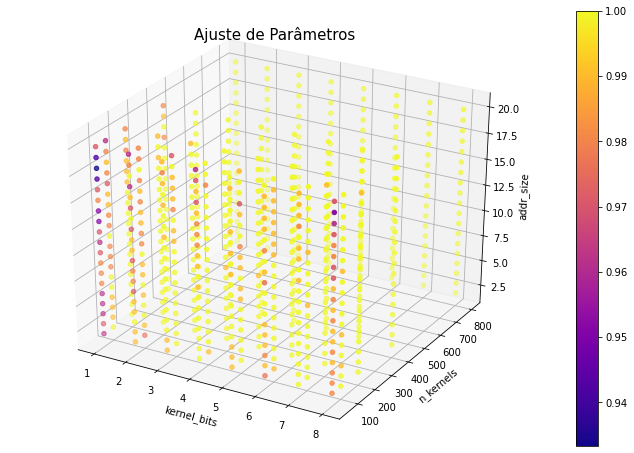

<Figure size 432x288 with 0 Axes>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
fig.set_size_inches(12,8)
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(x, y, z, c=c, cmap=plt.plasma())
fig.colorbar(img)
ax.set_xlabel('kernel_bits')
ax.set_ylabel('n_kernels')
ax.set_zlabel('addr_size')
plt.title('Ajuste de Parâmetros', size = 15)
plt.show()
plt.savefig("Parameter_tuning.png")

In [ ]:
print(resultados[1][400]['media_tempo'][3],resultados[1][400]['std_tempo'][3])

0.010572052001953125 0.0028980343313762123


In [ ]:
X_treino,y_treino = list(binarizar_conjunto_com_KernelCanvas(D_treino_padronizado,numberOfKernels=400,bitsByKernel=1,activationDegree=0.03).values())
X_teste,y_teste = list(binarizar_conjunto_com_KernelCanvas(D_teste_padronizado,numberOfKernels=400,bitsByKernel=1,activationDegree=0.03).values())
clf = wp.Wisard(2)
clf.train(X_treino,y_treino)
accuracy_score(y_teste,clf.classify(X_teste))

1.0

In [ ]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('/audio.wav','wb') as f:
    f.write(b)
  return '/audio.wav'  # or webm ?

In [ ]:
gravacao = record()

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

In [ ]:
!pip3 install unsilence

In [ ]:
!apt remove ffmpeg

In [ ]:
!apt install ffmpeg

In [ ]:
!ffmpeg -i /audio.wav -vn -ar 44100 -ac 2 -b:a 192k /audio.mp3

In [ ]:
!unsilence /audio.mp3 /unsilence.mp3 -y

In [ ]:
D_treino_padronizado['apple'][0].columns

Index(['mfcc_0_tempo(0)', 'mfcc_1_tempo(0)', 'mfcc_2_tempo(0)',
       'mfcc_3_tempo(0)', 'mfcc_4_tempo(0)', 'mfcc_5_tempo(0)',
       'mfcc_6_tempo(0)', 'mfcc_7_tempo(0)', 'mfcc_8_tempo(0)',
       'mfcc_9_tempo(0)', 'mfcc_10_tempo(0)', 'mfcc_11_tempo(0)',
       'mfcc_12_tempo(0)', 'mfcc_0_tempo(-1)', 'mfcc_1_tempo(-1)',
       'mfcc_2_tempo(-1)', 'mfcc_3_tempo(-1)', 'mfcc_4_tempo(-1)',
       'mfcc_5_tempo(-1)', 'mfcc_6_tempo(-1)', 'mfcc_7_tempo(-1)',
       'mfcc_8_tempo(-1)', 'mfcc_9_tempo(-1)', 'mfcc_10_tempo(-1)',
       'mfcc_11_tempo(-1)', 'mfcc_12_tempo(-1)', 'mfcc_0_tempo(-2)',
       'mfcc_1_tempo(-2)', 'mfcc_2_tempo(-2)', 'mfcc_3_tempo(-2)',
       'mfcc_4_tempo(-2)', 'mfcc_5_tempo(-2)', 'mfcc_6_tempo(-2)',
       'mfcc_7_tempo(-2)', 'mfcc_8_tempo(-2)', 'mfcc_9_tempo(-2)',
       'mfcc_10_tempo(-2)', 'mfcc_11_tempo(-2)', 'mfcc_12_tempo(-2)'],
      dtype='object')